In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, SeparableConv2D, Conv2DTranspose,concatenate
from tensorflow.keras.layers import MaxPooling2D
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from IPython.display import  display
from PIL import Image
import random
import cv2
import time 
from tensorflow.keras import backend as K
#from memory_profiler import profile
%matplotlib inline

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
#Helpful Tutorial



#https://towardsdatascience.com/model-sub-classing-and-custom-training-loop-from-scratch-in-tensorflow-2-cc1d4f10fb4e


In [3]:
class conv_block(keras.layers.Layer):
    def __init__(self,features,  rate, kernel = (3,3), pool_kernel = (2,2), activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal'):
        super(conv_block, self).__init__()
        
  
    
      
        self.conv1= Conv2D(features, kernel, activation =  activation,padding = padding, kernel_initializer = kernel_initializer)
        self.dropout1= Dropout(rate)
        self.conv2= Conv2D(features, kernel, activation =  activation,padding = padding, kernel_initializer = kernel_initializer)
        self.maxpool1 = MaxPool2D(pool_kernel, padding=padding )
        
    def call(self, input_tensor):
            
            conv1 = self.conv1(input_tensor)
        
            conv1 = self.dropout1(conv1)
             
            conv1 = self.conv2(conv1)
            
            pool1 = self.maxpool1(conv1)
  
            return conv1, pool1
            
            

In [4]:
class separable_conv_block(keras.layers.Layer):
    def __init__(self,features, rate, kernel = (3,3), pool_kernel = (2,2), activation = 'relu', padding = 'same'
                     , depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal'):
        super(separable_conv_block, self).__init__()
     
        
  
        
        self.s_conv1= SeparableConv2D(features, kernel, activation =  activation,padding = padding, depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.dropout2= Dropout(rate)
        self.s_conv2= SeparableConv2D(features, kernel, activation =  activation,padding = padding, depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.maxpool2 =  MaxPool2D(pool_kernel, padding=padding )
        
    def call(self, inputs):
     
        
            conv2 = self.s_conv1(inputs)
 
            conv2 = self.dropout2(conv2)

            conv2 = self.s_conv2(conv2)
             
            pool2 = self.maxpool2(conv2)
           
            return conv2,pool2
            
            

In [5]:
class out_sep_conv_block(keras.layers.Layer):
    def __init__(self,features, rate, kernel = (3,3), activation = 'relu', padding = 'same'
                     , depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal'):
        super(out_sep_conv_block, self).__init__()
     

        
        self.s_conv3= SeparableConv2D(features, kernel, activation =  activation,padding = padding , depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.dropout3 = Dropout(rate)
        self.s_conv4= SeparableConv2D(features, kernel, activation =  activation,padding = padding, depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)

        
    def call(self, inputs):
          
            conv3 = self.s_conv3(inputs)
      
            conv3 = self.dropout3(conv3)
           
            conv3 = self.s_conv4(conv3)
        
            
            return conv3
            

In [6]:
class conv_transpose(keras.layers.Layer):
    def __init__(self,features, rate,kernel_1 = (2,2), strides = (2,2), kernel_2 = (3,3), activation = 'relu', padding = 'same'
                     ,depthwise_initializer = 'he_normal', pointwise_initializer = 'he_normal'):
        super(conv_transpose, self).__init__()
        
 
        
        self.conv_trans= Conv2DTranspose( features, kernel_1, strides = strides, padding =padding)
        self.sep_conv1 = SeparableConv2D(features, kernel_2, activation =  activation,padding = padding , depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.drop = Dropout(rate)
        self.sep_conv2 = SeparableConv2D(features,kernel_2, activation =  activation,padding = padding , depthwise_initializer = depthwise_initializer, pointwise_initializer = pointwise_initializer)
        self.cat = tf.keras.layers.Concatenate()
    def call(self, inputs_1, inputs_2):
           
        
            up_conv = self.conv_trans(inputs_1)
       
            up_conv = self.cat([up_conv, inputs_2])
          
            conv4 = self.sep_conv1(up_conv)
            
            conv4 = self.drop(conv4)
   
            conv4 = self.sep_conv2(conv4)
        
    
            return conv4

In [7]:
class U_Encoder(keras.Model):
    def __init__(self, num_classes):
        super(U_Encoder, self).__init__()
       # self.inputs = inputs
        self.num_classes = num_classes
        self.conv1 =  conv_block(16, 0.1)
        self.conv2 =  separable_conv_block(32, 0.1)
        self.conv3 =  separable_conv_block(64, 0.2)
        self.conv4 =  separable_conv_block(128, 0.2)
        
        self.out_conv =  out_sep_conv_block(256, 0.1)
        
        self.up_conv1 = conv_transpose(128,0.2)
        self.up_conv2 = conv_transpose(64,0.2)
        self.up_conv3 = conv_transpose(32,0.1)
        self.up_conv4 = conv_transpose(16,0.1)
        
        #self.outp = Conv2D(num_classes,(1,1), activation = 'softmax'), Wnet version 
        self.out_layer = Conv2D(1,(1,1), activation = 'sigmoid') #Normal Unet version for testing.
       
        
        
    def call(self, inputs):
        

        
        con1,pol1 = self.conv1(inputs)
         
   
        con2,pol2 = self.conv2(pol1)
       
        con3,pol3 = self.conv3(pol2)
     
        con4,pol4 = self.conv4(pol3)
       
        con5 = self.out_conv(pol4)

        con6 = self.up_conv1(con5, con4)

        con7 = self.up_conv2(con6, con3)

        con8 = self.up_conv3(con7, con2)

        
        con9 = self.up_conv4(con8, con1)
       
        out = self.out_layer(con9)
    

        return out
        
        
        

In [8]:
def training_images():
    print('Resizing training images and masks')
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img  #Fill empty X_train with values from img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)  
            
        Y_train[n] = mask 
    return X_train, Y_train 

In [9]:
def load_and_noramlize_images():
    
    X = np.load('X_train.npy') 
    X_t = np.load('X_test.npy')
    Y = np.load('Y_train.npy')

    X_train = X.astype('float32') / 255
    X_t = X_t.astype('float32') / 255
    
    return X_train, X_t, Y
    



In [ ]:
def plot():
    
    plt

In [10]:
if __name__ == '__main__':
    
    seed = 42
    np.random.seed = seed

    IMG_WIDTH = 128
    IMG_HEIGHT = 128
    IMG_CHANNELS = 3
    X_train, X_t, Y = load_and_noramlize_images()

    model = U_Encoder(1)

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics =['accuracy'])

    checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only=True)

    callbacks  = [keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'), 
                      keras.callbacks.TensorBoard(log_dir= 'logs')]

    results = model.fit(X_train,Y, validation_split = 0.1, batch_size = 16, epochs = 25)
        #print("Total Time Taken is ", (time.time()-stime)/60)





    
    
    

Metal device set to: Apple M1
Epoch 1/25


2022-02-02 20:37:45.550580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-02 20:37:45.550720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-02 20:37:45.612219: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-02 20:37:45.612230: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-02 20:37:45.612302: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-02-02 20:37:45.626632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (register

38/38 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7729

2022-02-02 20:37:52.250820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 7s 155ms/step - loss: 0.6689 - accuracy: 0.7729 - val_loss: 0.6040 - val_accuracy: 0.8146
Epoch 2/25
38/38 [==============================] - 5s 139ms/step - loss: 0.5344 - accuracy: 0.7978 - val_loss: 0.4551 - val_accuracy: 0.8146
Epoch 3/25
38/38 [==============================] - 5s 143ms/step - loss: 0.4227 - accuracy: 0.7977 - val_loss: 0.3445 - val_accuracy: 0.8152
Epoch 4/25
38/38 [==============================] - 5s 140ms/step - loss: 0.3213 - accuracy: 0.8544 - val_loss: 0.2695 - val_accuracy: 0.8874
Epoch 5/25
38/38 [==============================] - 5s 138ms/step - loss: 0.2657 - accuracy: 0.8942 - val_loss: 0.2436 - val_accuracy: 0.8971
Epoch 6/25
38/38 [==============================] - 5s 137ms/step - loss: 0.2411 - accuracy: 0.9037 - val_loss: 0.2246 - val_accuracy: 0.9036
Epoch 7/25
38/38 [==============================] - 5s 137ms/step - loss: 0.2153 - accuracy: 0.9156 - val_loss: 0.2087 - val_accuracy: 0.9186
Epoch 8/25
38/38 

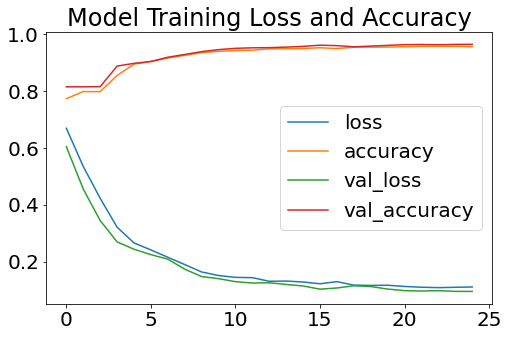

In [11]:
plt.rcParams.update({'font.size': 20})
pd.DataFrame(results.history).plot(figsize=(8,5))
plt.title('Model Training Loss and Accuracy')
plt.show()


In [12]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_t, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

 1/19 [>.............................] - ETA: 4s

2022-02-02 20:39:59.487158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 114ms/step


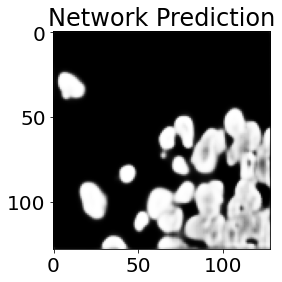

In [46]:
plt.title("Network Prediction")
plt.imshow(preds_train[200], cmap= 'gray')

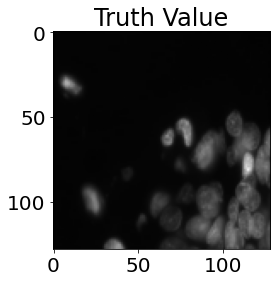

In [48]:
plt.title('Truth Value')
plt.imshow(X_train[200], cmap='gray')

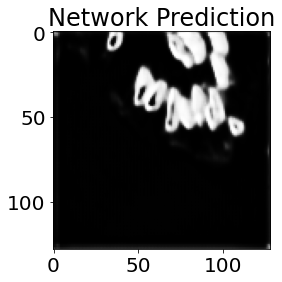

In [60]:
plt.title("Network Prediction")
plt.imshow(preds_test[25], cmap= 'gray')

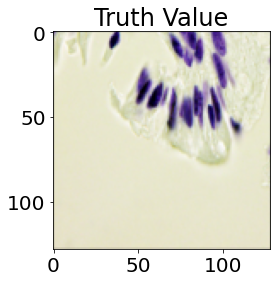

In [58]:
plt.title("Truth Value")
plt.imshow(X_t[25], cmap= 'gray')